# Timelag Comparison
Compute timelag results for NEI and IEQ results and compare the two cases for the cooling-only case.

In [2]:
import os
import sys

import numpy as np
from scipy.interpolate import splev
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
import sunpy
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels

sys.path.append('../../scripts/')
from timelags import AIATimeLags

%matplotlib inline

In [146]:
client = dask.distributed.Client(processes=False)
client

Client Scheduler: inproc://128.42.128.76/67945/1 Dashboard: http://localhost:8787,Cluster Workers: 1 Cores: 64 Memory: 270.38 GB


* Load results for NEI
* Load results for IEQ
* Compute timeseries for all channels
* Compare timeseries
* Compute timelags for selected channel pairs
* Compare timelag maps
* Compare timelag distributions

In [4]:
aia_nei = InstrumentSDOAIA([0,1e4] * u.s)
aia_nei.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/SDO_AIA_counts.h5'
timelags_nei = AIATimeLags(aia_nei, '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/')

FloatProgress(value=0.0)

In [5]:
aia_ieq = InstrumentSDOAIA([0,1e4] * u.s)
aia_ieq.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/ieq/SDO_AIA_counts.h5'
timelags_ieq = AIATimeLags(aia_ieq, '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/ieq/')

FloatProgress(value=0.0)

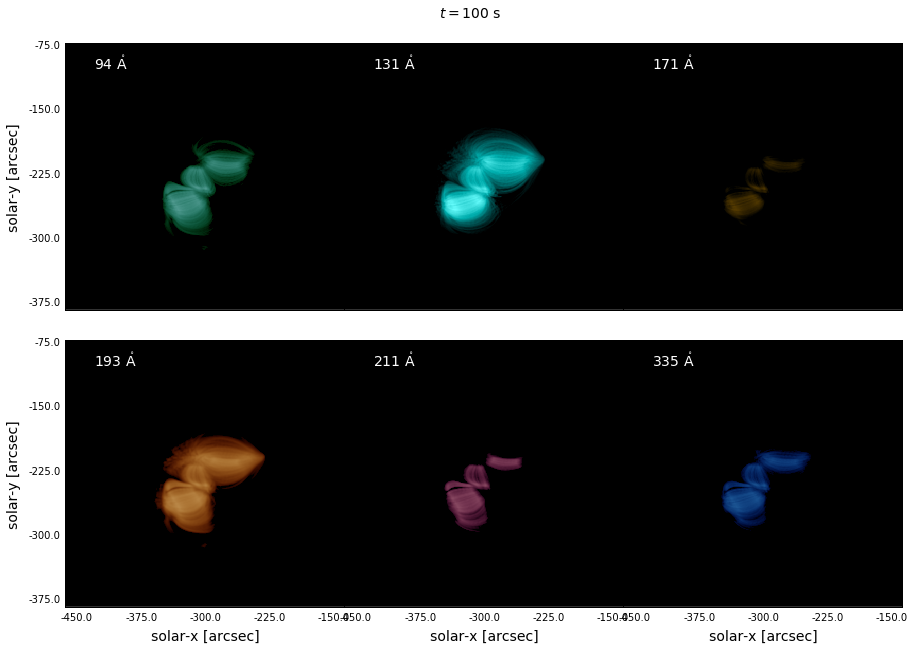

In [55]:
plot_aia_channels(aia_ieq, 100 * u.s, '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/ieq/')

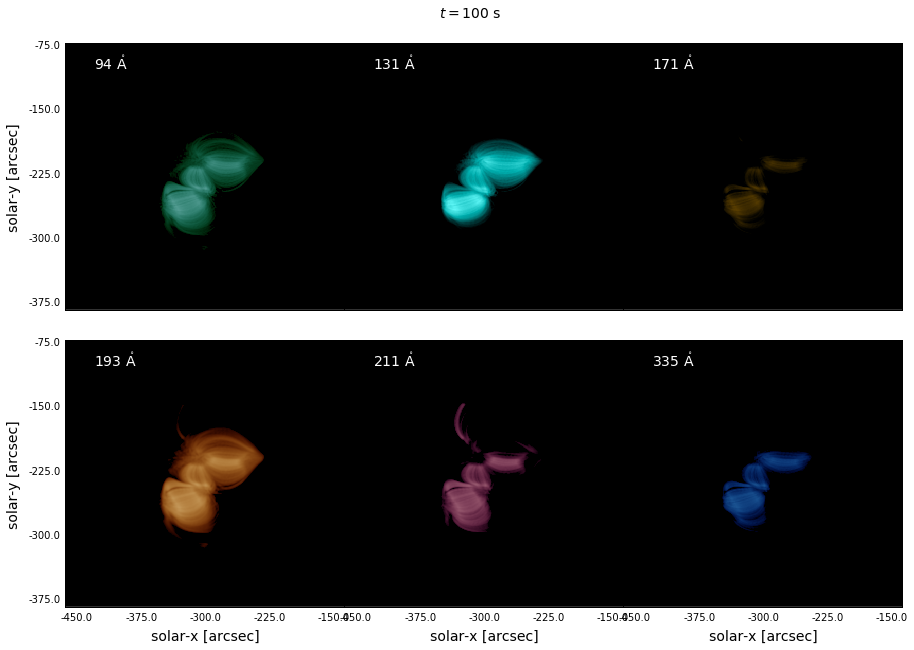

In [56]:
plot_aia_channels(aia_nei, 100 * u.s, '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/')

In [171]:
left_corner = (-300.5 * u.arcsec, -325 * u.arcsec)
right_corner = (-299.5 * u.arcsec, -150 * u.arcsec)

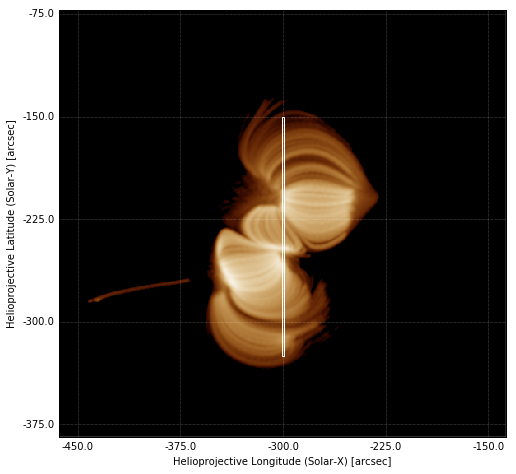

In [178]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/SDO_AIA/193/map_t000150.fits')
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection=m)
m.plot(axes=ax,title=False,norm=matplotlib.colors.SymLogNorm(1e-1,vmin=5,vmax=1e4))
m.draw_rectangle(SkyCoord(*left_corner,frame=m.coordinate_frame),
                 right_corner[0]-left_corner[0],
                 right_corner[1]-left_corner[1],
                 axes=ax,color='w',lw=1)

In [173]:
channel_pairs = [(94,335),(94,171),(335,211),(335,171),(193,171),(171,131)]
timeseries_nei = {}
correlation_nei = {}
for chan in aia_nei.channels:
    timeseries_nei[chan['name']] = timelags_nei.make_timeseries(timelags_nei.cubes, chan['name'],
                                                              left_corner, right_corner)
for ca,cb in channel_pairs:
    correlation_nei[f'{ca}_{cb}'] = timelags_nei.correlation_1d(f'{ca}',f'{cb}',left_corner,right_corner)

In [174]:
timeseries_ieq = {}
correlation_ieq = {}
for chan in aia_ieq.channels:
    timeseries_ieq[chan['name']] = timelags_ieq.make_timeseries(timelags_ieq.cubes, chan['name'],
                                                                left_corner, right_corner)
for ca,cb in channel_pairs:
    correlation_ieq[f'{ca}_{cb}'] = timelags_ieq.correlation_1d(f'{ca}',f'{cb}',left_corner,right_corner)

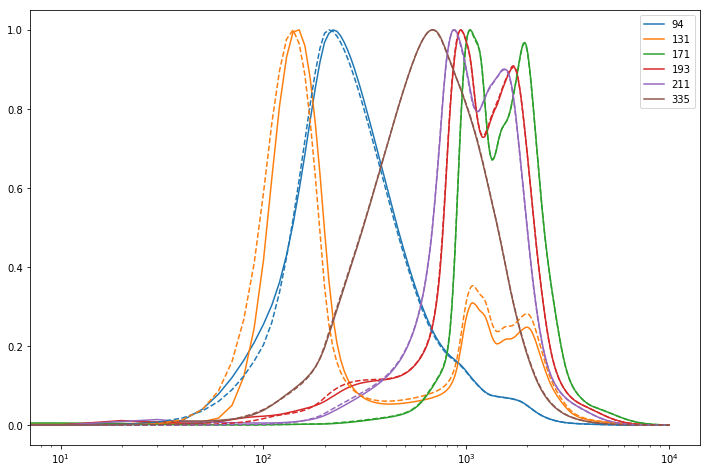

In [175]:
plt.figure(figsize=(12,8))
for i,k in enumerate(timeseries_nei):
    plt.plot(aia_nei.observing_time, timeseries_nei[k]/timeseries_nei[k].max(), 
             color=f'C{i}', label=k)
for i,k in enumerate(timeseries_ieq):
    plt.plot(aia_ieq.observing_time, timeseries_ieq[k]/timeseries_ieq[k].max(), 
             color=f'C{i}', ls='--')
plt.legend(loc=1)
plt.xscale('log')

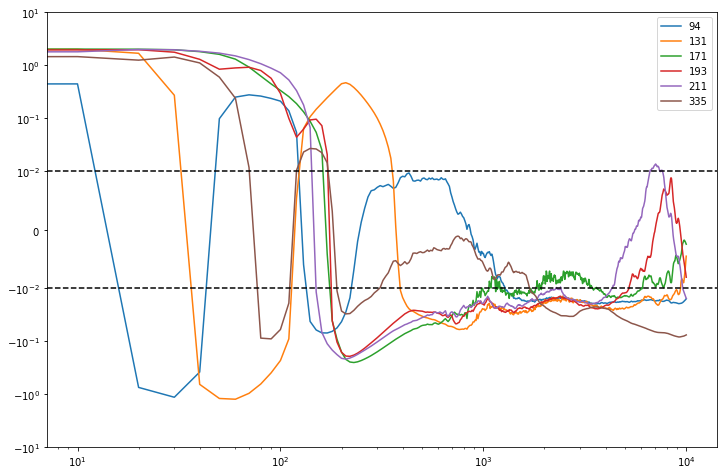

In [176]:
plt.figure(figsize=(12,8))
for i,k in enumerate(timeseries_nei):
    plt.plot(aia_nei.observing_time,
             (timeseries_nei[k] - timeseries_ieq[k])/((timeseries_nei[k] + timeseries_ieq[k])/2.), 
             color=f'C{i}', label=k)
plt.axhline(y=-0.01,color='k',ls='--')
plt.axhline(y=0.01,color='k',ls='--')
plt.xscale('log')
plt.yscale('symlog', linthreshy=0.01)
plt.ylim(-10,10)
plt.legend()

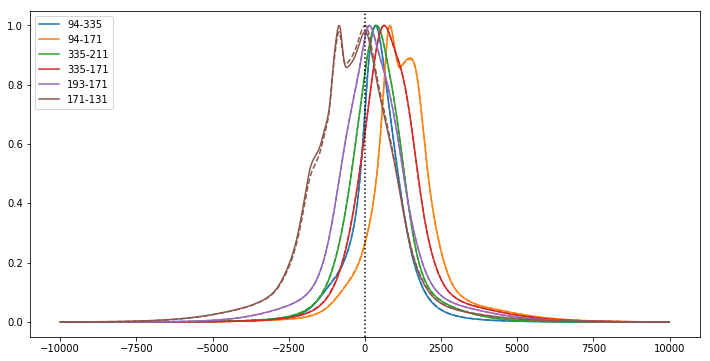

In [177]:
plt.figure(figsize=(12,6))
for i,(ca,cb) in enumerate(channel_pairs):
    plt.plot(timelags_nei.timelags,correlation_nei[f'{ca}_{cb}']/correlation_nei[f'{ca}_{cb}'].max(),
             f'C{i}',ls='-',label=f'{ca}-{cb}')
    plt.plot(timelags_ieq.timelags,correlation_ieq[f'{ca}_{cb}']/correlation_ieq[f'{ca}_{cb}'].max(),
             f'C{i}',ls='--')
plt.axvline(x=0,ls=':',color='k')
plt.legend(loc=2)
#plt.xlim(-6e3,6e3)

In [147]:
correlation_map_nei, timelag_map_nei = timelags_nei.make_timelag_map('193','171')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


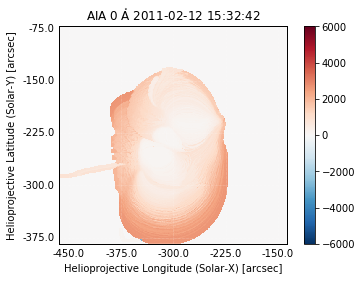

In [150]:
timelag_map_nei.peek(vmin=-6e3,vmax=6e3,cmap='RdBu_r')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


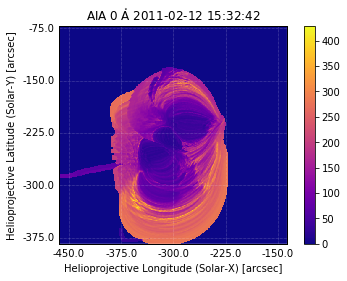

In [151]:
correlation_map_nei.peek()

In [152]:
correlation_map_ieq, timelag_map_ieq = timelags_ieq.make_timelag_map('193','171')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


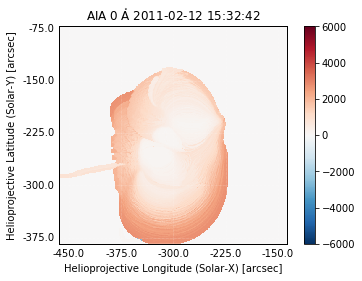

In [153]:
timelag_map_ieq.peek(vmin=-6e3,vmax=6e3,cmap='RdBu_r')

(-6000.0, 6000.0)

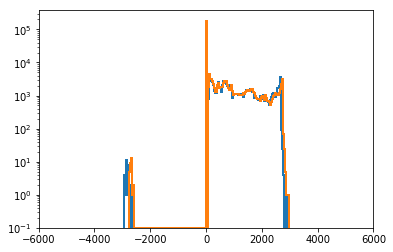

In [167]:
cor_filter = np.where(correlation_map_nei.data.flatten() >= 0.)
plt.hist(timelag_map_nei.data.flatten()[cor_filter],histtype='step',bins='scott',lw=2,log=True,ls='-');
cor_filter = np.where(correlation_map_ieq.data.flatten() >= 0.)
plt.hist(timelag_map_ieq.data.flatten()[cor_filter],histtype='step',bins='scott',lw=2,log=True,ls='-');
plt.xlim(-6e3,6e3)